### Load Factor Prediction Model

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#### Dataset
In the data folder of this project we build up a dataset of windfarms across the country at different dates and compared a set of weather factors to the load factor at that point in time.

We want to build a model that given some weather attributes (forecast or current) can accurately predict the percentage of the max generation capacity the wind farm will be generating (load factor). 

In [3]:
dataset = pd.read_csv('../Data/CurrentDataset.csv')


dataset['wgust'].replace('', np.nan, inplace=True)
dataset = dataset.dropna().drop('Unnamed: 0',axis=1)
y = dataset['loadFactor']
X = dataset.drop('BMUID',axis=1).drop('loadFactor',axis=1)
print(y.shape)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



(1601,)
(1601, 9)


#### Approaches

##### Linear Regression

In [4]:
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Visualise correlation between different variables of the dataset - highlights wspd most important factor and dew is very unimportant, also shows a potential correlation between low pressure and high loadfactor.

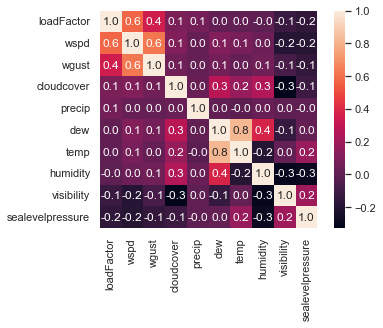

In [5]:

correlation = dataset.corr(method='pearson')
columns = correlation.nlargest(10, 'loadFactor').index

correlation_map = np.corrcoef(dataset[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True,
                      fmt='.1f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()


From this we can adjust the data a bit more and then evaluate a range of different models.
Below we scale & standardize the features, before running an evaluation of a set of different models to determine which performs best in our use case.
We here evaluate both linear and nonlinear models.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

print("Linear Models:\n")

potentialLinearModels = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', LassoCV()),
    ('ElasticNet', ElasticNet()),
    ('SGDRegressor', SGDRegressor())
]

results = []
names = []
for name, model in potentialLinearModels:
    pipeline = Pipeline(
        steps=[('preprocessor', scaler), ('classifier', model)])
    kfold = KFold(n_splits=30)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


print("\nNon-linear Models:\n")


potentialNonLinearModels = [
    ('DecisionTree Regressor', DecisionTreeRegressor()),
    ('KNN Regressor', KNeighborsRegressor()),
    ('GradBoost Regressor', GradientBoostingRegressor()),
    ('ADABoost Regressor', AdaBoostRegressor()),
    ('MLP Regressor', MLPRegressor())
]


results = []
names = []
for name, model in potentialNonLinearModels:
    pipeline = Pipeline(steps=[('preprocessor', scaler), ('regressor', model)])
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(
        pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


Linear Models:

Linear Regression: -0.068920 (0.024799)
Lasso: -0.068019 (0.023952)
ElasticNet: -0.102158 (0.028306)
SGDRegressor: -0.068827 (0.024575)

Non-linear Models:

DecisionTree Regressor: -0.099565 (0.010859)
KNN Regressor: -0.065425 (0.005400)
GradBoost Regressor: -0.058175 (0.003225)
ADABoost Regressor: -0.071762 (0.005056)
MLP Regressor: -0.061862 (0.005946)


Gradient Boosting Regressor Consistently the best performing model, therefore next step is to tune the hyperparameters to improve performance further.

MLP techniques also show good results so we will next use a GridSearchCV to optimise hyperparamters for both and evaluate their performance on our test dataset.

In [8]:
from sklearn.model_selection import GridSearchCV

# Model Definitions
MLP_pipeline = Pipeline(
    steps=[('preprocessor', scaler), ('regressor', MLPRegressor())])

# Parameter Grids
param_grid_MLP = {'regressor__max_iter': [200,300,500,1000],
                  'regressor__solver': ['adam','sgd'],
                  'regressor__alpha': [0.0001,0.0005,0.001],
                  'regressor__learning_rate': ['constant', 'adaptive'],
                  'regressor__learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 0.005, 0.05],
                  'regressor__hidden_layer_sizes':[(100,),(100,50,),(250,100,50,),(100,50,30)]
                  }

param_grid_grad_boost = {}

# Grid function definitions
grid_MLP = GridSearchCV(MLP_pipeline, param_grid_MLP,
                        verbose=2, refit=True, n_jobs=-1)

#Solve:
grid_MLP.fit(X_train,y_train)
print(grid_MLP.best_params_)
print(grid_MLP.best_score_)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
{'regressor__alpha': 0.0005, 'regressor__hidden_layer_sizes': (100, 50), 'regressor__learning_rate': 'adaptive', 'regressor__learning_rate_init': 0.001, 'regressor__max_iter': 200, 'regressor__solver': 'adam'}
0.42382558265910764


In [11]:
GradBoost_pipeline = Pipeline(
    steps=[('preprocessor', scaler), ('regressor',
                                      GradientBoostingRegressor())])

param_grid_grad_boost = {
    'regressor__learning_rate':[0.1,0.01,0.001,0.05],
    'regressor__max_depth':[3,4,5],
    'regressor__max_depth':[3,4,5],
    'regressor__criterion':['friedman_mse', 'squared_error', 'mse', 'mae'],
    'regressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

grid_gradBoost = GridSearchCV(GradBoost_pipeline,
                              param_grid_grad_boost,
                              verbose=2,
                              refit=True,
                              n_jobs=-1)

grid_gradBoost.fit(X_train, y_train)
print(grid_gradBoost.best_params_)
print(grid_gradBoost.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
             nan             nan  4.24322611e-01  4.47804846e-01
  4.49170904e-01 -5.78885120e-01 -4.84984848e-01 -3.85881239e-01
             nan             nan             nan             nan
             nan             nan  2.89442089e-01  3.07268095e-01
  3.27489249e-01 -1.14332056e+00 -1.07468844e+00 -1.01789464e+00
             nan             nan             nan             nan
             nan             nan  5.00208370e-03  9.39648998e-03
  1.23927631e-02 -2.00476436e+00 -1.98712928e+00 -1.96870405e+00
             nan             nan             nan             nan
             nan             nan  3.94628816e-01  4.25537674e-01
  4.43018354e-01 -6.29082934e-01 -5.64223537e-01 -4.80466537e-01
             nan             nan             nan             nan
             nan         

{'regressor__criterion': 'friedman_mse', 'regressor__learning_rate': 0.1, 'regressor__loss': 'huber', 'regressor__max_depth': 5}
0.44917090408441923
